# COMEXT GRAPHS ANALYSIS

## Import

In [ ]:
#@title COLAB ONLY CELL
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive',force_remount=True)
%cd /content/gdrive/MyDrive/COMEXT
%pip install -q -r ./comext_graph_analysis/requirements.txt
# %pip install ./networkx-2.8.2/networkx-networkx-2.8.2[default] --use-feature=in-tree-build

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/COMEXT


In [ ]:
#@title Import
import hashlib, random, math, os, sys, pickle, powerlaw, pysbm #,eurostat
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
from tqdm.notebook import tqdm
from networkx.classes.function import degree
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.append('/content/gdrive/MyDrive/COMEXT/comext_graph_analysis/src')
import graph_analysis as g

## Functions

In [ ]:
# with open("./comext_graph_analysis/src/graph_analysis.py","r") as f:
#     print(f.read())

In [ ]:
import hashlib, random, math, os, pickle, powerlaw, time
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
from networkx.readwrite import json_graph
from networkx.classes.function import degree
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from matplotlib import cm

full_columns = ['PRODUCT_CPA2_1', 'DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG']
full_types = {'PRODUCT_CPA2_1':str, 'DECLARANT_ISO':str, 'PARTNER_ISO':str, 'FLOW':int, 'PERIOD':str, 'VALUE_IN_EUROS':int, 'QUANTITY_IN_KG':int}

tr_columns = ['PRODUCT_NSTR', 'DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD', 'TRANSPORT_MODE', 'VALUE_IN_EUROS']
tr_types = {'PRODUCT_NSTR':str, 'DECLARANT_ISO':str, 'PARTNER_ISO':str, 'FLOW':int, 'PERIOD':str, 'TRANSPORT_MODE':int, 'VALUE_IN_EUROS':int}

tr_intra_columns = ['PRODUCT_NSTR', 'DECLARANT_ISO', 'PARTNER_ISO', 'FLOW', 'PERIOD', 'TRANSPORT_MODE', 'VALUE_IN_EUROS']
tr_intra_types = {'PRODUCT_NSTR':str, 'DECLARANT_ISO':str, 'PARTNER_ISO':str, 'FLOW':int, 'PERIOD':str, 'TRANSPORT_MODE':int, 'VALUE_IN_EUROS':int}


def load_filtered_data(table, save=False, verbose=1, force_reload=False, sorted=True, **params):
    """"load_filtered_data(table:str, save:bool, types:dict(type), columns:list, group_by_prod_code:bool, 
            n_digits:int, years=list(int), months=list(int)|None|"all", product:"all"|list(str), 
            flow:1|2|"all", trade_type:"I"|"E"|"all",  declarant_iso:str|"all", partner_iso:str|"all")
    """
    
    if verbose:
        print("loading",table,end=": ")

    def get_params_str_hash(params):
        str_params = {x:params[x] for x in params if x != "types"}
        # str_params = params
        # return str(str_params).replace("{","").replace("}","").replace("': ","_").replace("[","").replace("]","").replace(", ","_").replace("'","").replace("<class ","").replace(">","")
        return hashlib.sha256(str(str_params).encode("UTF_8")).hexdigest()

    def group_by_prod_code(table,**params):
        df = table.copy()
        column = df.columns[0]
        df[column] = df[column].str[:params["n_digits"]]
        return df.groupby(params["columns"][:-2],as_index=False).sum()
    
    if not force_reload and os.path.exists(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"):
        if not os.path.exists(f"./data-samples/manual/{table}/"):
            os.makedirs(f"./data-samples/manual/{table}/")
        if verbose:
            print("loading existing...",end=" ")
        df = pd.read_parquet(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet")
        if verbose:
            print("Table loaded")
        return df, None
    else:
        tic = time.time()
        prod_code_df = params["columns"][0]

        def build_filters(df,params,table,name,prod_code_df):
            filters = pd.Series([True for i in range(df.shape[0])])
            if isinstance(params["product"],list):
                filter_prod = ~filters.copy()
                not_f = []
                for p in params["product"]:
                    mask = (df[prod_code_df] == p)
                    if not mask.any():
                        not_f.append(p)
                    filter_prod = filter_prod | mask
                if verbose==2 and len(not_f) > 0:
                    print(','.join(not_f),f"not found in {table}{name}",end=", ")
                filters = filters & filter_prod
            elif params["product"] != "all":
                mask = (df[prod_code_df] == params["product"])
                if verbose==2 and not mask.any():
                    print(f"{params['product']} not found in {table}{name}",end=", ")
                filters = filters & mask
            if params["flow"] != "all":
                filters = filters & (df.FLOW == params["flow"])
            if table == "full" and params["trade_type"] != "all":
                filters = filters & (df.TRADE_TYPE == params["trade_type"])
            if isinstance(params["declarant_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["declarant_iso"]:
                    mask = (df["DECLARANT_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["declarant_iso"] != "all":
                mask = (df["DECLARANT_ISO"] == params["declarant_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['declarant_iso']} not found in {table}{name}",end=", ")
            if isinstance(params["partner_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["partner_iso"]:
                    mask = (df["PARTNER_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["partner_iso"] != "all":
                mask = (df["PARTNER_ISO"] == params["partner_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['partner_iso']} not found in {table}{name}",end=", ")
            
            if verbose==2 and not filters.any():
                print(f"\n\tempty df for {table}{name}")

            return filters

        if table not in ["full","tr","tr_intra_"]:
            raise Exception("table not valid")
        df = pd.DataFrame(columns=params["columns"])
        for y in tqdm(params["years"],leave=False):
            # if verbose:
            #     print(y,end=" ")
            if params["months"] is None:
                df_y = pd.read_parquet(f"./data-samples/{table}/Years/{table}{y}52.parquet",columns=params["columns"])
                if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                    df_y_filtered = group_by_prod_code(df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"]),**params)
                else:
                    df_y_filtered = df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"])
                df = pd.concat([df,df_y_filtered])
                del df_y, df_y_filtered
            elif params["months"] == "all":
                for m in tqdm(range(1,13),leave=False):
                    # if verbose:
                    #     print(str(m),end=" ")
                    df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                    if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                        df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                    else:
                        df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                    df = pd.concat([df,df_y_filtered])
                del df_ym, df_y_filtered
            else:
                for m in tqdm(params["months"],leave=False):
                    # if verbose:
                    #     print(str(m),end=" ")
                    df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                    if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                        df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                    else:
                        df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                    df = pd.concat([df,df_y_filtered])
                del df_ym, df_y_filtered
        if df.shape[0] == 0:
            if verbose:
                print("\n\tEmpty table")
            return df
        else:
            if sorted:
                df_out = df.groupby(params["columns"][:-1],as_index=False).sum().sort_values(params["columns"][-1],ascending=False).reset_index(drop=True)
            else:
                df_out = df.groupby(params["columns"][:-1],as_index=False).sum().reset_index(drop=True)            
            str_save = f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"
            if save:
                try:
                    df_out.to_parquet(str_save)
                    toc = time.time()
                    if verbose:
                        print("\nSuccessful saving",end="")
                        print(f",\t Table loaded in {(toc-tic):.1f} sec")
                    return df_out.astype(params["types"]), str_save
                except:
                    toc = time.time()
                    if verbose:
                        print("\nFailed saving",end="")
                        print(f",\t Table loaded in {(toc-tic):.1f} sec")
                    return df_out.astype(params["types"]), str_save
            else:
                return df_out.astype(params["types"]), str_save
                    
def combine_flows(df_to_combine, columns):

    # DEPRECATED
    # df_to_combine.sort_values(["TRADE_TYPE","FLOW"],inplace=True)
    # df_to_combine.reset_index(drop=True,inplace=True)
    # extra_import = df_to_combine[(df_to_combine.TRADE_TYPE == "E")&(df_to_combine.FLOW == 1)]
    # extra_export = df_to_combine[(df_to_combine.TRADE_TYPE == "E")&(df_to_combine.FLOW == 2)]
    # intra_import = df_to_combine[(df_to_combine.TRADE_TYPE == "I")&(df_to_combine.FLOW == 1)]
    # intra_export = df_to_combine[(df_to_combine.TRADE_TYPE == "I")&(df_to_combine.FLOW == 2)]
    # df_to_combine["country_to"] = pd.concat([extra_import['DECLARANT_ISO'],extra_export['PARTNER_ISO'],intra_import["DECLARANT_ISO"],intra_export["PARTNER_ISO"]])
    # df_to_combine["country_from"] = pd.concat([extra_import['PARTNER_ISO'],extra_export['DECLARANT_ISO'],intra_import["PARTNER_ISO"],intra_export["DECLARANT_ISO"]])
    # df_to_scale = df_to_combine.groupby(['TRADE_TYPE', 'PERIOD', 'country_from', 'country_to'],as_index=False)["VALUE_IN_EUROS"].mean()

    df4g = df_to_combine.copy()
    df_eu = df4g[df4g.PARTNER_ISO.isin(df4g.DECLARANT_ISO.unique())]
    df_ex = df4g[~df4g.PARTNER_ISO.isin(df4g.DECLARANT_ISO.unique())]
    # df_eu
    df_to_avg = df_eu[df_eu.FLOW == 1].merge(df_eu[df_eu.FLOW ==2][["DECLARANT_ISO","PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]]
                                            ,left_on=["DECLARANT_ISO","PARTNER_ISO"]
                                            ,right_on=["PARTNER_ISO","DECLARANT_ISO"]
                                            ,how="inner",suffixes=("","_y"))
    df_to_avg["VALUE_IN_EUROS"] = (df_to_avg["VALUE_IN_EUROS"] + df_to_avg["VALUE_IN_EUROS_y"])/2
    df_to_avg["QUANTITY_IN_KG"] = (df_to_avg["QUANTITY_IN_KG"] + df_to_avg["QUANTITY_IN_KG_y"])/2
    df_to_avg["VALUE_IN_EUROS_diff"] = np.abs(df_to_avg["VALUE_IN_EUROS"] - df_to_avg["VALUE_IN_EUROS_y"])
    df_to_avg["QUANTITY_IN_KG_diff"] = np.abs(df_to_avg["QUANTITY_IN_KG"] - df_to_avg["QUANTITY_IN_KG_y"])
    df_eu_l = [df_eu[df_eu.FLOW == 1].merge(df_eu[df_eu.FLOW ==2][["DECLARANT_ISO","PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]]
                                            ,left_on=["DECLARANT_ISO","PARTNER_ISO"]
                                            ,right_on=["PARTNER_ISO","DECLARANT_ISO"]
                                            ,how="outer",suffixes=("","_y")
                                            ,indicator=True).query('_merge=="left_only"')[columns]
            ,df_to_avg[columns]
            ,df_ex[df_ex.FLOW == 1]
            ,df_ex[df_ex.FLOW == 2].rename({"DECLARANT_ISO":"PARTNER_ISO","PARTNER_ISO":"DECLARANT_ISO"},axis=1)[columns]]
    df_to_scale = pd.concat(df_eu_l)
    df_to_scale["country_from"] = df_to_scale.PARTNER_ISO
    df_to_scale["country_to"] = df_to_scale.DECLARANT_ISO # cannot look at flow anymore from now on
    return df_to_scale, df_to_avg
    
def extract_table_for_graph(df_in, y="2020", flow="all", criterio="VALUE_IN_EUROS", scale_by=None, pop_df=None, transport_mode=None, threshold_cs=1., threshold_abs=0.):

    df_to_filter = df_in.copy()
    filters = True
    if "TRANSPORT_MODE" in df_to_filter.columns:
        if transport_mode is None:
            df_to_filter = df_to_filter.groupby(df_to_filter.columns[:-2].to_list(),as_index=False)[criterio].sum()
        else:
            filters = filters & (df_to_filter.TRANSPORT_MODE == transport_mode)
    filters &= (df_to_filter.DECLARANT_ISO != "EU") & (df_to_filter.PARTNER_ISO != "EU")
    if flow != "all":
        filters &= (df_to_filter.FLOW == flow)

    df_to_combine = df_to_filter[filters].reset_index(drop=True)
    if flow == "all":
        df_to_scale = combine_flows(df_to_combine, df_in.columns)
    else:
        if flow == 1:
            country_from = "PARTNER_ISO"
            country_to = "DECLARANT_ISO"
        elif flow == 2:
            country_from = "DECLARANT_ISO"
            country_to = "PARTNER_ISO"

    assert scale_by in [None, 'population','in_edges','out_edges']
    if scale_by == 'in_edges':
        # DEPRECATED
        divider = df_to_scale.groupby(country_to,as_index=False)[criterio].sum()
        df = df_to_scale.merge(divider,on=country_to,suffixes=("","_TOT"))
        df[criterio+"_SCALED"] = df[criterio] / df[criterio+"_TOT"]
        df = df[df[criterio+"_SCALED"] >= threshold_abs].sort_values(criterio+"_SCALED",ascending=False)
    elif scale_by == 'population':
        if pop_df is None:
            pop_df, eu_iso = load_population_df()
        y_ = "2020" if y == "2021" else y
        df_out = df_to_scale.merge(pop_df[[y_]],left_on="country_to",right_on="iso2")
        for crit in ["VALUE_IN_EUROS","QUANTITY_IN_KG"]:
            df_out[crit+"_SCALED"] = df_out[crit] / df_out[y_]
            df_out[crit+"_RESCALED"] = df_out[crit+"_SCALED"] / df_out[crit+"_SCALED"].sum()
            # df["VALUE_IN_EUROS_MM"] = MinMaxScaler().fit_transform(df["VALUE_IN_EUROS_SCALED"].to_numpy().reshape((-1,1)))[:,0]
        df_out.sort_values("VALUE_IN_EUROS_RESCALED",ascending=False,inplace=True)
        df_out = df_out[df_out["VALUE_IN_EUROS_RESCALED"].cumsum() <= threshold_cs].reset_index(drop=True)
        # Old method
        # df = df[df["VALUE_IN_EUROS_SCALED"] > threshold].sort_values(criterio+"_SCALED",ascending=False)
    elif scale_by == 'out_edges':
        df_out = df_to_scale.copy()
    else:
        df_out = df_to_scale.copy()
    return df_out.rename_axis(y,axis=1)#, df_to_scale

def get_world_countries(df_pop, eu_iso, year=2020):
    y = "2020" if str(year) == "2021" else str(year) 
    df_pop_dict = df_pop[str(y)].to_dict()
    nodes = []
    for k in df_pop_dict:
        nodes.append((k,{"pop":df_pop_dict[k],"eu":(k in eu_iso.tolist())}))
    return nodes

def calc_metrics(G,y="2021"): 

    def vulnerability(in_deg):
        """Opposite of in-degree-percentage: (1-d)%
        """
        vulner = {}
        for k, v in in_deg.items():
            if v != 0 :      
                vulner[k] = 1 - v
            else:
                vulner[k] = 0 
        return vulner

    def adjusted_density(G,y):
        n_ctr = G.number_of_nodes() # which is len(df_pop.iso2.unique())
        n_ctr_eu = 27 if int(y) >= 2020 else 28
        n_ctr_ex = n_ctr - n_ctr_eu
        return G.number_of_edges() / (n_ctr_eu*(n_ctr_eu-1)+2*n_ctr_ex*n_ctr_eu)

    metrics={
             "edges": G.number_of_edges(),
             "nodes": G.number_of_nodes(),
             "size": G.size("weight"),
             "degree": dict(nx.degree(G)),
             "degree_perc": nx.degree_centrality(G),
             "out_degree": dict(G.out_degree),
             "out_degree_perc": nx.out_degree_centrality(G),
             "in_degree": dict(G.in_degree),
             "in_degree_perc": nx.in_degree_centrality(G),
             "density": nx.density(G),
             "density_adj": adjusted_density(G,y),
             "clustering": nx.clustering(G),
             "page_rank": nx.pagerank(G)
            # "betweenness_centrality":nx.betweenness_centrality(G), # SP not interesting
            # "hubness": nx.closeness_centrality(G.to_undirected()) # SP not interesting
        }
    
    metrics["vulnerability"] = vulnerability(metrics["in_degree_perc"])

    if nx.number_of_nodes(G) != 0:
        adj_mat = nx.adjacency_matrix(G).toarray()
        adj_df = pd.DataFrame(adj_mat,columns=G.nodes(),index=G.nodes())
        metrics["in_weight_degree"] = adj_df.sum(axis=0).to_dict()
        metrics["out_weight_degree"] = adj_df.sum(axis=1).to_dict()

    for degree in ["degree","in_degree","out_degree","in_weight_degree","out_weight_degree"]:
        # if len(np.unique(metrics[degree])) <= 2:
        #     metrics[degree+"_gamma"] = np.nan
        #     metrics[degree+"_xmin"] = 0
        # else:
            # try:
            # d_s = pd.Series(metrics[degree])
            # x, y = d_s[d_s != 0].value_counts().index, d_s[d_s != 0].value_counts().values
            # y = y / y.sum()
            # y_log, x_log = np.log(y), np.log(x)
            # power_law = lambda x, a, b: a*(x**b)
            # par, cov = curve_fit(f=power_law,xdata=x,ydata=y)
            # metrics[degree+"_exponent"] = par[1]
            # metrics[degree+"_coef"] = par[0]
        results = powerlaw.Fit([metrics[degree][k] for k in metrics[degree]],verbose=False)
        metrics[degree+"_gamma"] = results.power_law.alpha
        metrics[degree+"_xmin"] = results.power_law.xmin
    
    return pd.DataFrame(metrics)

def makeGraph(tab_edges, tab_nodes=None, pos_ini=None, weight_flag=False, criterio="VALUE_IN_EUROS", threshold=0.001, compute_layout=False):
    if tab_nodes is None:
        df_pop, eu_iso = load_population_df()
        tab_nodes = get_world_countries(df_pop, eu_iso, year=int(tab_edges.columns.name))

    G = nx.DiGraph()
    edges = []
    if weight_flag == True:
        for i,j,w in tab_edges.loc[:,["country_from","country_to",criterio+"_SCALED"]].values:
            if i == "EU" or j == "EU":
                print(i,j)
            edges += [(i,j,w)]
    else:
        for i,j in tab_edges.loc[:,["country_from","country_to"]].values:
            if i == "EU" or j == "EU":
                print(i,j)
            edges += [(i,j,1)]

    G.add_nodes_from(tab_nodes)
    G.add_weighted_edges_from(edges)

    # Calcolo le metriche
    MetricG = calc_metrics(G, y=tab_edges.columns.name)
    MetricG = MetricG.merge(tab_edges.groupby(["country_from"])[criterio].sum().rename("out_weight_abs"),left_index=True,right_index=True,how="left")\
                     .merge(tab_edges.groupby(["country_to"])[criterio].sum().rename("in_weight_abs"),left_index=True,right_index=True,how="left").fillna(0)
    MetricG.index.name = "country"

    if compute_layout:
        if pos_ini is None:
            pos_ini = {}
            random.seed(8)
            for node in G.nodes():
                x = random.uniform(0, 1000)
                y = random.uniform(0, 1000)
                pos_ini[node] = np.array([x,y])
        # coord = nx.spring_layout(G,k=5/math.sqrt(G.order()))

    return pos_ini, MetricG, G
    
def node_metrics_ts(metrics_df, node, prod=None):
    if prod is None:
        prod = "TO"
    if node != "world":
        return metrics_df[(metrics_df.country == node)&(metrics_df["prod"]==prod)].reset_index(drop=True).copy()
    else:
        fmdf_gr = metrics_df.groupby(["year","month","prod"],as_index=False).sum()
        return fmdf_gr[fmdf_gr["prod"] == prod].reset_index(drop=True).copy()

# def node_metrics_ts(metrics_dict, node, prod=None):
#     node_rows = []
#     for k in metrics_dict:
#         ym, _, p = k.split("_")
#         if prod == None:
#             prod = p
#         if prod == p:
#             node_rows.append(pd.concat([pd.Series(ym,index=["date"],name="IT"),metrics_dict[k].loc["IT"]]))
#     return pd.DataFrame(node_rows).set_index("date")
#     # return node_rows
    
def load_population_df(y_from=2000,y_to=2021):
    if not os.path.exists("./data-samples/population/df_pop.csv"):
        pop_un = pd.read_csv("./data-samples/population/population_un.csv",na_values="",keep_default_na=False)
        code_to_iso3 = pd.read_csv("./data-samples/population/countryUN_to_iso3.csv",na_values="",keep_default_na=False)
        iso3_to_iso2 = pd.read_csv("./data-samples/population/iso3_to_iso2.csv",na_values="",keep_default_na=False)
        df_pop_merge = pop_un.merge(code_to_iso3[['LocID', 'ISO3_Code']],left_on='Country code',right_on='LocID').merge(iso3_to_iso2[['alpha-3','alpha-2']], left_on='ISO3_Code',right_on='alpha-3')
        df_pop = df_pop_merge[df_pop_merge.columns[-1:].append(df_pop_merge.columns[7:-4])].astype({str(y):float for y in range(1950,2021)})
        df_pop_clean = df_pop.rename({"alpha-2":"iso2"},axis=1)[["iso2"]+[str(y) for y in range(y_from,y_to)]].sort_values("iso2").reset_index(drop=True).fillna("NA") #, df_pop_merge
        df_pop_clean.to_csv("./data-samples/population/df_pop.csv",index=False)
        return df_pop_clean.set_index("iso2"), pd.read_table("./data-samples/population/eu_iso2.txt")["Alpha-2"]
    else:
        return pd.read_csv("./data-samples/population/df_pop.csv",na_filter=False).set_index("iso2"), pd.read_table("./data-samples/population/eu_iso2.txt")["Alpha-2"]

files_dict = {"full":pd.read_table("./data-samples/nomenclature/CPA2_1.txt",header=None).rename({0:"code",1:"name"},axis=1),
                "tr":pd.read_table("./data-samples/nomenclature/NSTR.txt",header=None).rename({0:"code",1:"name"},axis=1),
                "tr_intra_":pd.read_table("./data-samples/nomenclature/NSTR.txt",header=None).rename({0:"code",1:"name"},axis=1)}

def get_cat_name(table,code,files_dict=files_dict):
    assert table in ["full","tr","tr_intra_"]
    nom = files_dict[table]
    try:
        name = nom[nom["code"]==code].iloc[0]["name"]
        return name
    except:
        print("Index not existing")
        return "Unknown"

def plot_bar_metr(metrics_df,country="IT",metr="density",log=False):
    ita_in = metrics_df[(metrics_df.country == country)&(metrics_df["prod"] != "TO")]
    # ita_in = metrics_df[(metrics_df.country == "IT")]
    ita_pivot = ita_in[["year","month","prod",metr]].reset_index(drop=True).pivot(index=["year","month"], columns=["prod"])
    if not log:
        ita_pivot.mean(axis=0).reset_index(level=0,drop=True).rename({i:i+" "+get_cat_name("full",i)[:30] for _,i in ita_pivot.columns},axis=0)\
                 .sort_values(ascending=False).plot.bar(figsize=(20,8))
        plt.ylabel(metr)
    else:
        np.log10(ita_pivot.mean(axis=0)).reset_index(level=0,drop=True).rename({i:i+" "+get_cat_name("full",i)[:30] for _,i in ita_pivot.columns},axis=0)\
                 .sort_values(ascending=False).plot.bar(figsize=(20,8))
        plt.ylabel("log "+metr)
    # plt.xticks(rotation=45, rotation_mode="anchor", position=(0.1,-0.11))
    plt.axhline(y=0,color="k",linewidth=0.5)
    plt.title("Mean "+metr+" across time for "+country)
    # plt.show()
    
def plot_cat_ts(metrics_df, prod=None, metr="density", country="world", moving_avg=None, log=False):
    df = node_metrics_ts(metrics_df,node=country,prod=prod)
    df["date"] = df.year + df.month
    df.set_index("date",inplace=True)
    title = metr.capitalize() + " of " + country + " for " + get_cat_name("full",prod) + " from 2001 to 2021"
    if moving_avg is None:
        if log:
            np.log10(df[[metr]]).plot(figsize=(20,8),label=metr)
            title = "Log " + title 
        else:
            df[[metr]].plot(figsize=(20,8),label=metr)
    else:
        if log:
            df['MA'] = np.log10(df[metr]).rolling(window=moving_avg).mean()
            title = "Log " + title + ", with rolling average of " + str(moving_avg) + " months"
        else:
            df['MA'] = df[metr].rolling(window=moving_avg).mean()
            title += ", with rolling average of " + str(moving_avg) + " months"
        df.MA.plot(figsize=(20,8),label=metr)
    plt.legend()
    plt.ylabel(metr)
    plt.grid()
    plt.title(title,fontsize=14)

def plot_power_law(metr_df,metric):
    y,x = np.histogram(metr_df[metric],bins=100,density=True)
    x = np.array([np.mean([x[i],x[i+1]]) for i in range(len(x)-1)])
    x = x[y > 0]
    y = y[y > 0]
    x_log = np.log10(x)
    y_log = np.log10(y)
    results = powerlaw.Fit(metr_df[metric].to_numpy(),xmin=1.)
    l = np.linspace(3,np.max(x))
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
    # ax1
    ax1.plot(l,l**(-results.power_law.alpha),color="r",label=f"powerlaw, gamma = {results.power_law.alpha:.4}")
    ax1.scatter(x,y,label=metric+" distribution")
    ax1.set_xlabel(metric)
    ax1.set_ylabel("P("+metric+")")
    ax1.legend()
    # ax2
    l = np.linspace(0,np.max(x_log))
    ax2.plot(l,l*(-results.power_law.alpha),color="r",label=f"powerlaw, gamma = {results.power_law.alpha:.4}")
    ax2.scatter(x_log,y_log,label=metric+" distribution")
    ax2.set_xlabel("log("+metric+")")
    ax2.set_ylabel("log( P("+metric+") )")
    ax2.legend()

    plt.suptitle("Power Law fit of "+metric+" in 01/2021",fontsize=16)
    plt.show()

## Variables

Count the number of declarant countries in the years

In [ ]:
# if str_save_full is not None:
#     df_full.to_parquet(str_save_full)
# df_tr_intra, str_save_tr_intra = load_filtered_data("tr_intra_", save=True, columns=tr_intra_columns, types=tr_intra_types,
#                              years=[2021], months=[2], product="all", flow="all", declarant_iso="all", partner_iso="all")
# # if str_save_tr_intra is not None:
# #     df_tr_intra.to_parquet(str_save_tr_intra)
# df_tr, str_save_tr = load_filtered_data("tr", save=True, columns=tr_columns, types=tr_types, group_by_prod_code=True, n_digits=2,
#                              years=[y for y in range(2020,2021)], months=None, product=[str(i) for i in range(141,149)], flow="all", declarant_iso="all", partner_iso="all")
# # if str_save_tr is not None:
# #     df_tr.to_parquet(str_save_tr)

In [ ]:
df_full, str_save_full = load_filtered_data("full", save=True, force_reload=True, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                             years=[2012], months=None, product=["0"+str(i) for i in range(600,699)], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")
# df_full, str_save_full = g.load_filtered_data("full", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
#                              years=[2012], months=None, product=["TOTAL"], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")
# df_full2 = pd.read_csv("./data-samples/full201252.dat",na_filter=False)

loading full: 

  0%|          | 0/1 [00:00<?, ?it/s]


Successful saving,	 Table loaded in 60.6 sec


In [ ]:
df_full, str_save_full = load_filtered_data("full", save=True, verbose=0, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                             years=[2012], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

### Differences

In [ ]:
# diffs = {}
for y in range(2008,2022):
    print(y)
    if not os.path.exists(f"./data-samples/diff_full_df{y}.parquet"):
        df_full, str_save_full = load_filtered_data("full", save=True, verbose=0, force_reload=True, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                             years=[y], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")
        differences = {}
        for prod in tqdm(df_full.PRODUCT_CPA2_1.unique(),leave=False):
            df_full_prod = df_full[df_full.PRODUCT_CPA2_1 == prod].copy()
            df_f_p_comb, df_to_avg = combine_flows(df_full_prod,full_columns)
            differences[prod] = df_to_avg
        diff_df = pd.concat([differences[prod].set_index(["DECLARANT_ISO","PARTNER_ISO"])[["VALUE_IN_EUROS_diff"]].rename({"VALUE_IN_EUROS_diff":prod+" "+get_cat_name("full",prod)[:30]},axis=1) for prod in differences],axis=1)
        diff_df.to_parquet(f"./data-samples/diff_full_df{y}.parquet")
    else:
        diffs[y] = pd.read_parquet(f"./data-samples/diff_full_df{y}.parquet")

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [ ]:
diff_df = diffs[2012]

In [ ]:
diff_df[diff_df.max().sort_values(ascending=False).index[:20]]

06 Crude petroleum and natural ga     TO Total  \
DECLARANT_ISO PARTNER_ISO                                                   
AT            BE                                         NaN  214686276.0   
              BG                                         NaN   12706707.5   
              CY                                         NaN   13563028.0   
              CZ                                   1612815.5  190881232.5   
              DE                                   1826548.5  546280132.0   
...                                                      ...          ...   
SK            PL                                         NaN   87946677.0   
              PT                                         NaN    5838934.5   
              RO                                         NaN   67677395.5   
              SE                                         NaN   72541045.0   
              SI                                         NaN   74342224.0   

                           MM Adjustments ( broken down at c  \
DECLARANT_ISO PARTNER_ISO                                      
AT            BE                                         NaN   
              BG                                         NaN   
              CY                                         NaN   
              CZ                                         NaN   
              DE                                 898726083.5   
...                                                      ...   
SK            PL                                         NaN   
              PT                                         NaN   
              RO                                         NaN   
              SE                                         NaN   
              SI                                         NaN   

                           21 Basic pharmaceutical products   \
DECLARANT_ISO PARTNER_ISO                                      
AT            BE                                    137274.0   
              BG                                    348666.5   
              CY                                     82750.0   
              CZ                                  11817007.5   
              DE                                 125016016.5   
...                                                      ...   
SK            PL                                    164379.0   
              PT                                    111011.0   
              RO                                    319845.0   
              SE                                     95337.0   
              SI                                   1561421.0   

                           30 Other transport equipment  \
DECLARANT_ISO PARTNER_ISO                                 
AT            BE                              3228082.5   
              BG                              5705606.0   
              CY                                    NaN   
              CZ                             39046710.0   
              DE                              1279655.0   
...                                                 ...   
SK            PL                             15292941.0   
              PT                               295172.5   
              RO                               842948.5   
              SE                              1797213.5   
              SI                               229356.5   

                           20 Chemicals and chemical product  \
DECLARANT_ISO PARTNER_ISO                                      
AT            BE                                  87466763.5   
              BG                                    781122.0   
              CY                                    946211.0   
              CZ                                   3868898.5   
              DE                                 331310360.5   
...                                                      ...   
SK            PL                                  20014962.0   
              P

In [ ]:
df_full[df_full.PARTNER_ISO.isin(["IE","BE"])&df_full.DECLARANT_ISO.isin(["IE","BE"])&(df_full.PRODUCT_CPA2_1 == "21")]

,PRODUCT_CPA2_1,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
12081,21,BE,IE,1,201252,7566073712,56798400
12495,21,IE,BE,2,201252,10094082162,53003483
49991,21,BE,IE,2,201252,282128997,1416300
58448,21,IE,BE,1,201252,272313926,789270


In [ ]:
differences["WW"]

,PRODUCT_CPA2_1,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,DECLARANT_ISO_y,PARTNER_ISO_y,VALUE_IN_EUROS_y,QUANTITY_IN_KG_y,VALUE_IN_EUROS_diff,QUANTITY_IN_KG_diff
0,WW,DE,GB,1,201252,505317109.0,788834.0,GB,DE,128468,396,505188641.0,788438.0
1,WW,GB,DE,1,201252,202367155.5,432934.0,DE,GB,404161149,852514,201793993.5,419580.0


In [ ]:
df_agg = df_full.groupby(["DECLARANT_ISO","PARTNER_ISO","FLOW"],as_index=False)[["VALUE_IN_EUROS","QUANTITY_IN_KG"]].sum().sort_values("VALUE_IN_EUROS",ascending=False)

In [ ]:
df_full2[g.full_columns][df_full2.PRODUCT_CPA2_1 == "TOTAL"]

,PRODUCT_CPA2_1,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
14575,TOTAL,FR,NL,1,201252,37835126728,19449359657
14576,TOTAL,FR,NL,2,201252,18494671847,16479405471
31002,TOTAL,FR,DE,1,201252,100018840018,42392990203
31003,TOTAL,FR,DE,2,201252,72235953511,27409722826
46413,TOTAL,FR,IT,1,201252,39329728857,20300041751
...,...,...,...,...,...,...,...
8039644,TOTAL,CY,QV,2,201252,274650,0
8039661,TOTAL,CY,QW,1,201252,1188892,1839254
8039662,TOTAL,CY,QW,1,201252,21643,10745
8039663,TOTAL,CY,QW,1,201252,7464988,6


In [ ]:
df_full.sort_values("VALUE_IN_EUROS",ascending=False)

,PRODUCT_CPA2_1,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
0,TO,NL,DE,2,201252,132384023576,177465225666
1,TO,DE,NL,1,201252,125872499562,143346628989
19,TO,DE,FR,2,201252,102439478985,32625366854
12,TO,FR,DE,1,201252,100018840018,42392990203
143,TO,DE,US,2,201252,86374904782,7957469457
...,...,...,...,...,...,...,...
11144,TO,IE,CC,1,201252,3,0
11056,TO,RO,BJ,1,201252,2,1
11166,TO,IE,TJ,2,201252,1,0
11122,TO,BG,TO,2,201252,1,0


## Graphs scaled by population

In [ ]:
df4g = df_full.copy()
t4g = g.extract_table_for_graph(df4g, y="2012", flow="all", scale_by='population')
coord, metrics, G = makeGraph(t4g, weight_flag=True, compute_layout=True)
metrics.sort_values("out_weight_degree", ascending=False)

,edges,nodes,size,degree,degree_perc,out_degree,out_degree_perc,in_degree,in_degree_perc,density,...,in_degree_gamma,in_degree_xmin,out_degree_gamma,out_degree_xmin,in_weight_degree_gamma,in_weight_degree_xmin,out_weight_degree_gamma,out_weight_degree_xmin,out_weight_abs,in_weight_abs
country,,,,,,,,,,,,,,,,,,,,,
GR,10162,256,6.609814e+06,361,1.415686,188,0.737255,173,0.678431,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,9.237635e+11,1.868650e+12
IT,10162,256,6.609814e+06,435,1.705882,215,0.843137,220,0.862745,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,1.772055e+13,1.716162e+13
RO,10162,256,6.609814e+06,360,1.411765,190,0.745098,170,0.666667,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,2.186849e+12,3.086573e+12
IQ,10162,256,6.609814e+06,54,0.211765,26,0.101961,28,0.109804,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,2.552295e+10,9.277875e+09
QZ,10162,256,6.609814e+06,18,0.070588,18,0.070588,0,0.000000,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,4.339381e+10,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BQ,10162,256,6.609814e+06,0,0.000000,0,0.000000,0,0.000000,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,0.000000e+00,0.000000e+00
BL,10162,256,6.609814e+06,0,0.000000,0,0.000000,0,0.000000,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,0.000000e+00,0.000000e+00
SS,10162,256,6.609814e+06,0,0.000000,0,0.000000,0,0.000000,0.155668,...,44.370821,223.0,2.553393,18.0,1.475458,831.171529,1.271221,1.196114,0.000000e+00,0.000000e+00


In [ ]:
plt.figure(figsize=(40,30),dpi=200)
edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
m = max(edg_color)
edg_color = [(i/m)*256+30 for i in edg_color]
nx.draw_networkx(G, pos=coord, edge_color="orange", width=[i/60 for i in edg_color], font_color="white", font_size=8, node_size=200)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

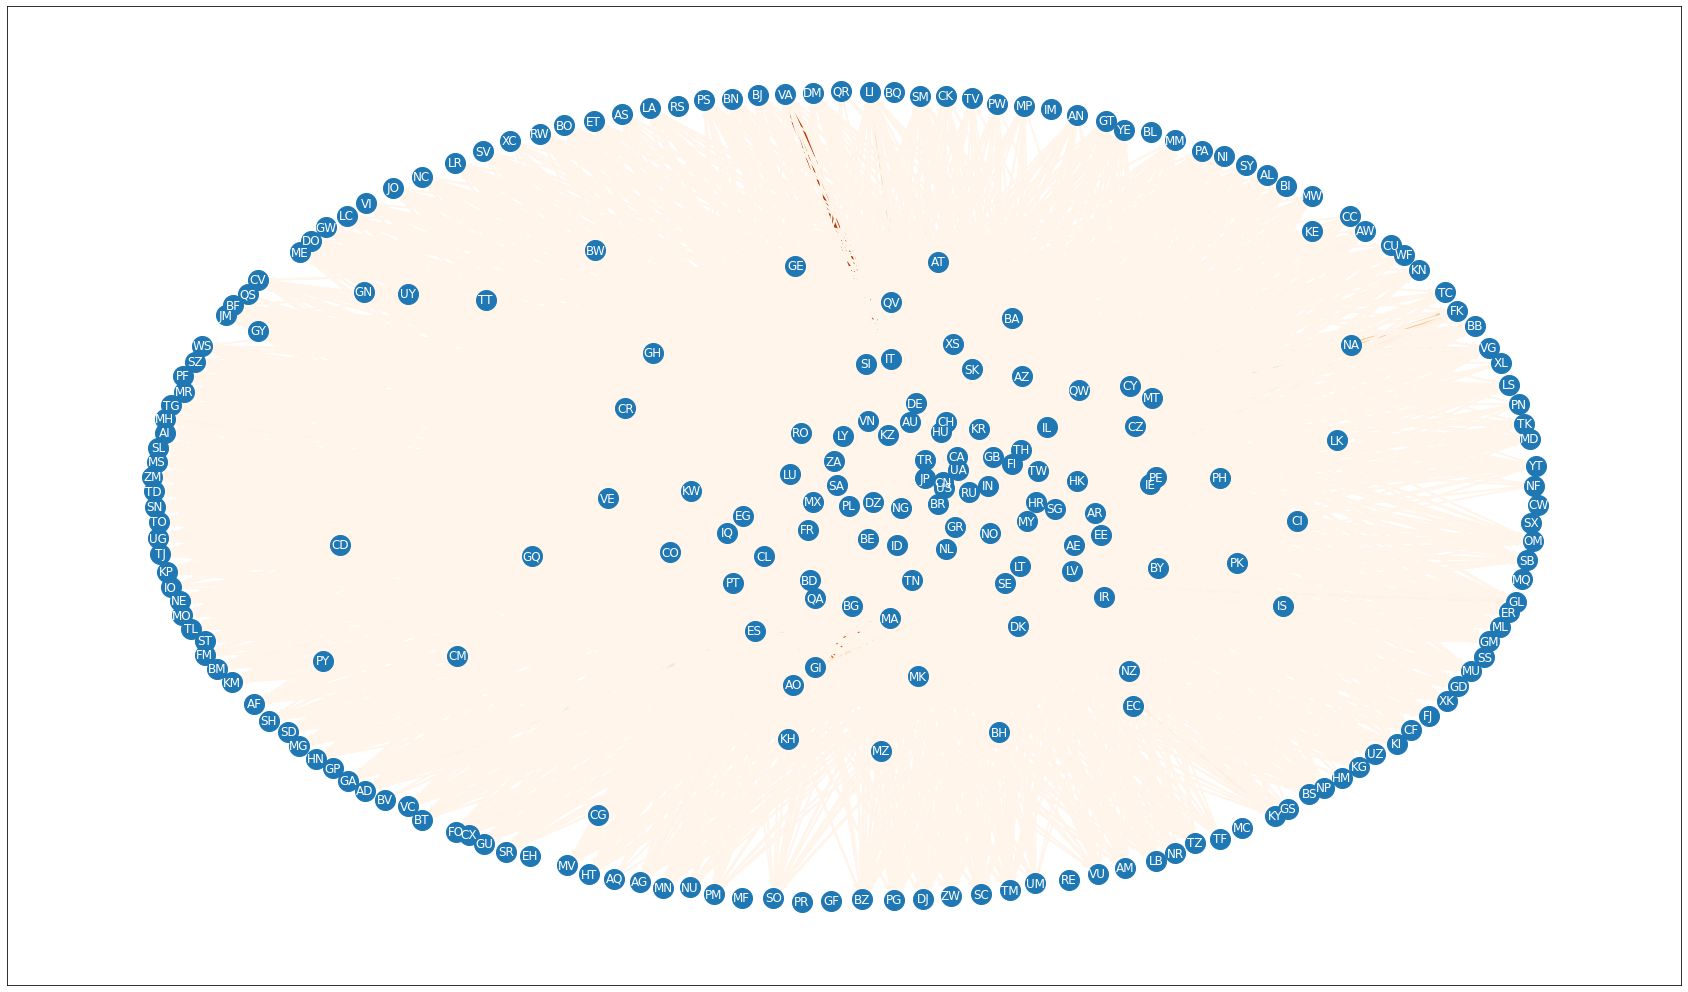

In [ ]:
plt.figure(figsize=(40,30),dpi=200)
edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
m = max(edg_color)
edg_color = [(i/m)*256+30 for i in edg_color]
nx.draw_networkx(G, pos=coord, edge_color=edg_color, edge_cmap=plt.get_cmap("Oranges"), width=[i/60 for i in edg_color], font_color="white", node_size=400)
plt.show()

## Gexf

In [ ]:
# nx.write_gexf(G,"./data-samples/graphs/full2012_06.gexf")
G2 = nx.read_gexf("./data-samples/graphs/full2012_06_lay.gexf",version="1.1draft")

NetworkXError: ignored

## Cliques

In [ ]:
import networkx.algorithms.community as nx_comm
G = nx.complete_graph(50)
K5 = nx.convert_node_labels_to_integers(G, first_label=2)
G.add_edges_from(K5.edges())
c = list(nx_comm.k_clique_communities(G, 4))

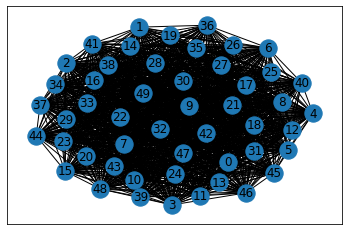

In [ ]:
nx.draw_networkx(nx.complete_graph(50))

In [ ]:
len(list(nx_comm.k_clique_communities(G.to_undirected(),2))[0])

244

## SBM

In [ ]:
standard_partition = pysbm.NxPartition(
    graph=G, 
    number_of_blocks=2)
degree_corrected_partition = pysbm.NxPartition(
    graph=G, 
    number_of_blocks=2,
    representation=standard_partition.get_representation())
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=False)
degree_corrected_objective_function = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False)

In [ ]:
position = nx.spring_layout(G)
plt.figure(figsize=(30,18))
nx.draw(G, coord, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in G], edge_color="orange", width=[i/30 for i in edg_color])
plt.show()
plt.figure(figsize=(30,18))
nx.draw(G, coord, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in G], edge_color="orange", width=[i/30 for i in edg_color])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
standard_inference = pysbm.MetropolisHastingInference(G, standard_objective_function, standard_partition)
degree_corrected_inference = pysbm.MetropolisHastingInference(G, degree_corrected_objective_function, degree_corrected_partition)
standard_inference.infer_stochastic_block_model()
degree_corrected_inference.infer_stochastic_block_model()

In [ ]:
print("Standard SBM with the splitting into high and low degree nodes")
nx.draw(G, coord, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in G])
plt.show()
print("Degree Corrected SBM")
nx.draw(G, coord, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in G])
plt.show()

# Extra

## Namibia

In [ ]:
# for y,m in tqdm([(y,m) for y in range(2001,2022) for m in range(1,13)]):
#     df = pd.read_parquet(f"./data-samples/full/Months/full{y*100+m}.parquet")
#     df.PARTNER_ISO = df.PARTNER_ISO.fillna("NA")
#     df.to_parquet(f"./data-samples/full/Months/full{y*100+m}.parquet")

In [ ]:
# for y,m in tqdm([(y,m) for y in range(2001,2022) for m in [52]]):
#     df = pd.read_parquet(f"./data-samples/full/Years/full{y*100+m}.parquet")
#     df.PARTNER_ISO = df.PARTNER_ISO.fillna("NA")
#     df.to_parquet(f"./data-samples/full/Years/full{y*100+m}.parquet")

In [ ]:
# for y,m in tqdm([(y,m) for y in range(2010,2022) for m in [i for i in range(1,13)]+[52]]):
#     YM = "Months" if m < 13 else "Years"
#     df = pd.read_parquet(f"./data-samples/tr/{YM}/tr{y*100+m}.parquet")
#     df.PARTNER_ISO = df.PARTNER_ISO.fillna("NA")
#     df.to_parquet(f"./data-samples/tr/{YM}/tr{y*100+m}.parquet")

# for y,m in tqdm([(y,m) for y in range(2010,2022) for m in [i for i in range(1,13)]+[52]]):
#     YM = "Months" if m < 13 else "Years"
#     df = pd.read_parquet(f"./data-samples/tr_intra_/{YM}/tr_intra_{y*100+m}.parquet")
#     df.PARTNER_ISO = df.PARTNER_ISO.fillna("NA")
#     df.to_parquet(f"./data-samples/tr_intra_/{YM}/tr_intra_{y*100+m}.parquet")